In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
# INSTALL RAPIDS
!cp ../input/rapids/rapids.0.16.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

In [3]:
!pip install -q /kaggle/input/iterative-stratification/iterative-stratification-master/

In [4]:
from fastai.basics import *

In [5]:
datapath = Path("/kaggle/input/lish-moa")

In [6]:
datapath.ls().map(lambda o: o.name)

(#6) ['test_features.csv','train_drug.csv','train_features.csv','train_targets_scored.csv','train_targets_nonscored.csv','sample_submission.csv']

In [7]:
train_features_df = pd.read_csv(datapath/'train_features.csv')
test_features_df = pd.read_csv(datapath/'test_features.csv')
train_targets_scored_df = pd.read_csv(datapath/'train_targets_scored.csv')
train_targets_nonscored_df = pd.read_csv(datapath/'train_targets_nonscored.csv')

In [8]:
train_features_df.shape, test_features_df.shape, train_targets_scored_df.shape, train_targets_nonscored_df.shape

((23814, 876), (3982, 876), (23814, 207), (23814, 403))

In [9]:
nonscored_cols = list(train_targets_nonscored_df.columns[1:])
scored_cols = list(train_targets_scored_df.columns[1:])

In [10]:
len(nonscored_cols), len(scored_cols)

(402, 206)

In [11]:
assert set(nonscored_cols).intersection(scored_cols) == set()

In [12]:
train_features_df.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [13]:
test_features_df.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380


In [14]:
train_targets_scored_df.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


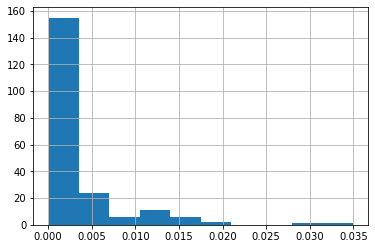

In [15]:
train_targets_scored_df.iloc[1:].mean().hist()

In [16]:
train_target_distrib = dict(train_targets_scored_df.iloc[:,1:].sum())

In [17]:
train_target_distrib;

In [18]:
[(k,train_target_distrib[k]) for k in train_target_distrib if train_target_distrib[k] == 1]

[('atp-sensitive_potassium_channel_antagonist', 1), ('erbb2_inhibitor', 1)]

In [19]:
n_train, n_test = train_features_df.shape[0], test_features_df.shape[0]
train_test_features_df = pd.concat([train_features_df, test_features_df]).reset_index(drop=True)
g_cols = list(o for o in train_test_features_df.columns if o.startswith("g-"))
c_cols = list(o for o in train_test_features_df.columns if o.startswith("c-"))
gc_cols = g_cols + c_cols

len(g_cols), len(c_cols), len(gc_cols)

(772, 100, 872)

### Feature Distributions

In [20]:
from seaborn import distplot

In [21]:
def plot_dist():
    fig, axes = plt.subplots(2, 5, figsize=(15,6))
    axes = axes.flatten()
    for c, ax in zip(list(np.random.choice(c_cols, 5))+list(np.random.choice(g_cols,5)), axes): distplot(train_test_features_df[c], ax=ax)

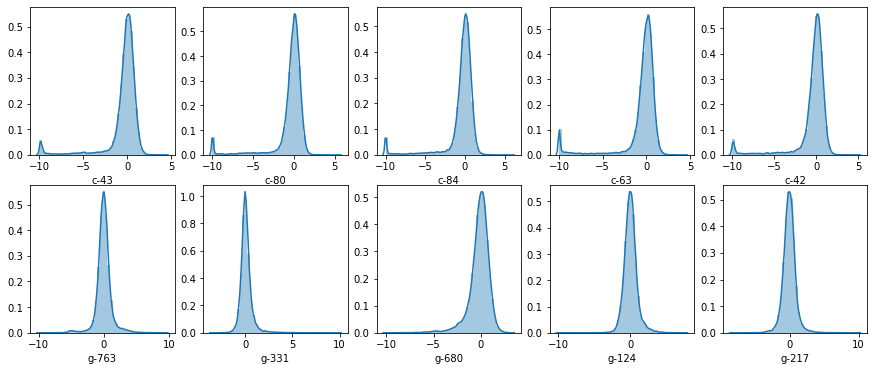

In [22]:
plot_dist()

### Config

Useful for hyperparameter search

In [23]:
ParamConfig = SimpleNamespace(
    do_rank_gauss = True,
    
    do_quantile_tfms = False,
    n_quantiles = 100,
    
    do_pca = False,
    pca_reduction_factor = 3,

    do_umap = False,
    umap_reduction_factor = 3,
    umap_n_neighbors = 150,
    
    do_knn_encoding = True,
    knn_k = 100,
    
    do_transfer_learning = False,
    tl_n_epochs = 30,
    tl_smoothing = 0.001,
    tl_lr = 0.001,
    
    ft_n_epochs = 30,
    ft_smoothing = 0.001,
    ft_lr = 0.001,
    
    model_n_layers = 2,
    model_layer_width = 512,
    model_ps = 0.25
)

### RankGauss

In [24]:
import cupy as cp
from cupyx.scipy.special import erfinv
import cudf as gd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import erfinv as sp_erfinv

In [25]:
def to_rankgauss(x):
    "https://medium.com/rapids-ai/gauss-rank-transformation-is-100x-faster-with-rapids-and-cupy-7c947e3397da"
    x_cpu = x
    r_cpu = x_cpu.argsort().argsort() 
    epsilon = 1e-6
    r_cpu = (r_cpu/r_cpu.max()-0.5)*2 # scale to (-1,1)
    r_cpu = cp.clip(r_cpu,-1+epsilon,1-epsilon)
    r_cpu = sp_erfinv(r_cpu) # map to gaussian
    return r_cpu

In [26]:
if ParamConfig.do_rank_gauss: 
    for col in gc_cols: 
        train_test_features_df[col] = to_rankgauss(train_test_features_df[col])

### QuantileTransform

In [27]:
from sklearn.preprocessing import QuantileTransformer

In [28]:
if ParamConfig.do_quantile_tfms:
    transformer = QuantileTransformer(n_quantiles=ParamConfig.n_quantiles, random_state=0, output_distribution="normal")
    train_test_features_df[gc_cols] = transformer.fit_transform(train_test_features_df[gc_cols])

### Plot Dist

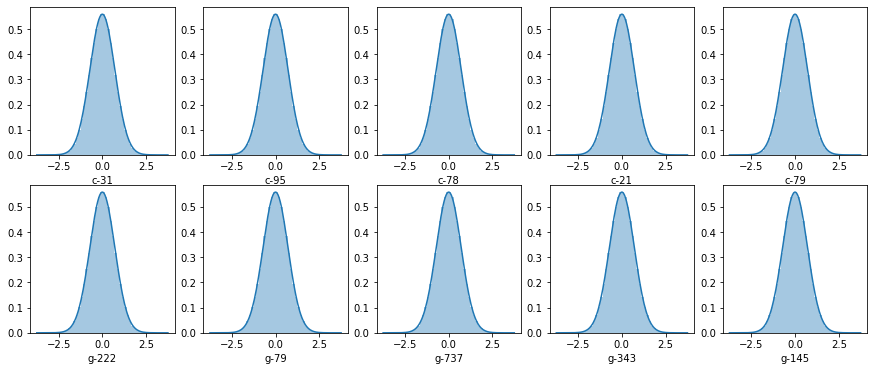

In [29]:
plot_dist()

In [30]:
len(g_cols), len(c_cols), len(gc_cols)

(772, 100, 872)

In [31]:
train_test_features_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,0.811862,0.637635,-0.295499,-0.679958,-0.180395,-0.722071,...,0.286615,0.255864,0.915477,0.587517,-0.171056,0.719498,-0.358171,0.220227,0.380169,0.456696
1,id_000779bfc,trt_cp,72,D1,0.092119,0.479000,0.193867,0.064208,0.854236,0.487861,...,-0.373041,0.796641,0.507467,0.032885,0.288416,0.524192,0.142233,0.124447,0.646689,0.821929
2,id_000a6266a,trt_cp,48,D1,0.558472,0.664726,1.010345,-0.084792,-0.000925,1.057900,...,-0.590043,-0.528145,0.674209,0.031991,-0.864109,-0.276812,-0.540276,-0.199435,-0.802685,0.767948
3,id_0015fd391,trt_cp,48,D1,-0.516251,-0.195391,-0.312074,0.542755,1.742240,-0.609969,...,-1.014254,-0.539081,-1.167488,-0.891249,-0.671402,-0.874427,-0.939749,-0.695616,-0.346188,-0.650964
4,id_001626bd3,trt_cp,72,D2,-0.314677,-0.340018,0.689641,0.690976,1.037826,-0.617964,...,0.010044,0.000159,0.742678,1.187645,0.561001,-0.264940,0.102419,0.298425,-0.339160,0.790417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,trt_cp,24,D1,0.431529,-0.489480,1.707286,-0.679553,0.761539,1.267887,...,-0.822430,-0.537462,-0.370624,0.026566,-0.541729,-0.411043,-0.854501,-0.826962,-0.368650,-0.549027
27792,id_ff925dd0d,trt_cp,24,D1,-0.595025,-0.201427,1.424900,0.363546,0.457639,0.305900,...,0.026821,0.600495,-0.481489,0.883262,0.969898,1.412962,0.254707,-0.251511,-0.027651,-0.070485
27793,id_ffb710450,trt_cp,72,D1,-0.393798,-0.106416,0.167053,-0.741130,0.049301,0.451289,...,0.456539,0.977468,-0.165217,0.421585,0.999492,0.498761,0.038695,0.628874,-0.370771,-0.124382
27794,id_ffbb869f2,trt_cp,48,D2,-1.133474,-1.376823,-0.437151,0.939749,-1.152549,-0.185934,...,0.311231,-0.389412,-0.627077,0.852651,0.308142,0.143535,-0.245136,0.540105,0.810876,-0.030012


In [32]:
train_test_features_df.groupby(['cp_type', 'cp_time', 'cp_dose'])[['sig_id']].count()

sig_id
cp_type     cp_time cp_dose        
ctl_vehicle 24      D1          359
                    D2          363
            48      D1          408
                    D2          364
            72      D1          366
                    D2          364
trt_cp      24      D1         4175
                    D2         4175
            48      D1         4671
                    D2         4184
            72      D1         4195
                    D2         4172

In [33]:
len(train_test_features_df['sig_id'].unique())

27796

In [34]:
# ctl_vehicle have no MoA hence all 0 target labels
all(train_test_features_df.merge(train_targets_scored_df, on='sig_id').query("cp_type == 'ctl_vehicle'")[scored_cols].sum()==0)

True

In [35]:
# ctl_vehicle have no MoA hence all 0 target labels
all(train_test_features_df.merge(train_targets_nonscored_df, on='sig_id').query("cp_type == 'ctl_vehicle'")[nonscored_cols].sum()==0)

True

In [36]:
test_features_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,id_ff7004b87,trt_cp,24,D1,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-1.1790,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600
3978,id_ff925dd0d,trt_cp,24,D1,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.0210,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934
3979,id_ffb710450,trt_cp,72,D1,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.4418,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504
3980,id_ffbb869f2,trt_cp,48,D2,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,0.3079,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484


### PCA

In [37]:
from cuml.decomposition import PCA as cumlPCA

In [38]:
%%time
if ParamConfig.do_pca:
    # add pca features
    pca_feats = []
    colnames = []
    for name, cols in [("gene", g_cols), ("cell", c_cols)]:
        n_comp = int(len(cols)/ParamConfig.pca_reduction_factor)
        pca = cumlPCA(n_components=n_comp, iterated_power=500)
        pca_feat = pca.fit_transform(train_test_features_df[cols])
        pca_feats += [pca_feat]
        colnames += [f"pca_{name}_{i}" for i in range(n_comp)]
        
    pca_feats = np.hstack(pca_feats)
    train_test_features_df[colnames] = pca_feats

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.34 µs


In [39]:
train_test_features_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,0.811862,0.637635,-0.295499,-0.679958,-0.180395,-0.722071,...,0.286615,0.255864,0.915477,0.587517,-0.171056,0.719498,-0.358171,0.220227,0.380169,0.456696
1,id_000779bfc,trt_cp,72,D1,0.092119,0.479000,0.193867,0.064208,0.854236,0.487861,...,-0.373041,0.796641,0.507467,0.032885,0.288416,0.524192,0.142233,0.124447,0.646689,0.821929
2,id_000a6266a,trt_cp,48,D1,0.558472,0.664726,1.010345,-0.084792,-0.000925,1.057900,...,-0.590043,-0.528145,0.674209,0.031991,-0.864109,-0.276812,-0.540276,-0.199435,-0.802685,0.767948
3,id_0015fd391,trt_cp,48,D1,-0.516251,-0.195391,-0.312074,0.542755,1.742240,-0.609969,...,-1.014254,-0.539081,-1.167488,-0.891249,-0.671402,-0.874427,-0.939749,-0.695616,-0.346188,-0.650964
4,id_001626bd3,trt_cp,72,D2,-0.314677,-0.340018,0.689641,0.690976,1.037826,-0.617964,...,0.010044,0.000159,0.742678,1.187645,0.561001,-0.264940,0.102419,0.298425,-0.339160,0.790417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,trt_cp,24,D1,0.431529,-0.489480,1.707286,-0.679553,0.761539,1.267887,...,-0.822430,-0.537462,-0.370624,0.026566,-0.541729,-0.411043,-0.854501,-0.826962,-0.368650,-0.549027
27792,id_ff925dd0d,trt_cp,24,D1,-0.595025,-0.201427,1.424900,0.363546,0.457639,0.305900,...,0.026821,0.600495,-0.481489,0.883262,0.969898,1.412962,0.254707,-0.251511,-0.027651,-0.070485
27793,id_ffb710450,trt_cp,72,D1,-0.393798,-0.106416,0.167053,-0.741130,0.049301,0.451289,...,0.456539,0.977468,-0.165217,0.421585,0.999492,0.498761,0.038695,0.628874,-0.370771,-0.124382
27794,id_ffbb869f2,trt_cp,48,D2,-1.133474,-1.376823,-0.437151,0.939749,-1.152549,-0.185934,...,0.311231,-0.389412,-0.627077,0.852651,0.308142,0.143535,-0.245136,0.540105,0.810876,-0.030012


### UMAP

In [40]:
from cuml.manifold import UMAP as cumlUMAP

In [41]:
%%time
# add umap features
if ParamConfig.do_umap:
    umap_feats = []
    colnames = []
    for name, cols in [("gene", g_cols), ("cell", c_cols)]:
        n_comp = int(len(cols)/ParamConfig.umap_reduction_factor)
        umap = cumlUMAP(n_components=n_comp, n_neighbors=ParamConfig.umap_n_neighbors)
        umap_feat = umap.fit_transform(train_test_features_df[cols])
        umap_feats += [umap_feat]
        colnames += [f"umap_{name}_{i}" for i in range(n_comp)]

    umap_feats = np.hstack(umap_feats)
    train_test_features_df[colnames] = umap_feats

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 9.54 µs


In [42]:
train_test_features_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,0.811862,0.637635,-0.295499,-0.679958,-0.180395,-0.722071,...,0.286615,0.255864,0.915477,0.587517,-0.171056,0.719498,-0.358171,0.220227,0.380169,0.456696
1,id_000779bfc,trt_cp,72,D1,0.092119,0.479000,0.193867,0.064208,0.854236,0.487861,...,-0.373041,0.796641,0.507467,0.032885,0.288416,0.524192,0.142233,0.124447,0.646689,0.821929
2,id_000a6266a,trt_cp,48,D1,0.558472,0.664726,1.010345,-0.084792,-0.000925,1.057900,...,-0.590043,-0.528145,0.674209,0.031991,-0.864109,-0.276812,-0.540276,-0.199435,-0.802685,0.767948
3,id_0015fd391,trt_cp,48,D1,-0.516251,-0.195391,-0.312074,0.542755,1.742240,-0.609969,...,-1.014254,-0.539081,-1.167488,-0.891249,-0.671402,-0.874427,-0.939749,-0.695616,-0.346188,-0.650964
4,id_001626bd3,trt_cp,72,D2,-0.314677,-0.340018,0.689641,0.690976,1.037826,-0.617964,...,0.010044,0.000159,0.742678,1.187645,0.561001,-0.264940,0.102419,0.298425,-0.339160,0.790417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,trt_cp,24,D1,0.431529,-0.489480,1.707286,-0.679553,0.761539,1.267887,...,-0.822430,-0.537462,-0.370624,0.026566,-0.541729,-0.411043,-0.854501,-0.826962,-0.368650,-0.549027
27792,id_ff925dd0d,trt_cp,24,D1,-0.595025,-0.201427,1.424900,0.363546,0.457639,0.305900,...,0.026821,0.600495,-0.481489,0.883262,0.969898,1.412962,0.254707,-0.251511,-0.027651,-0.070485
27793,id_ffb710450,trt_cp,72,D1,-0.393798,-0.106416,0.167053,-0.741130,0.049301,0.451289,...,0.456539,0.977468,-0.165217,0.421585,0.999492,0.498761,0.038695,0.628874,-0.370771,-0.124382
27794,id_ffbb869f2,trt_cp,48,D2,-1.133474,-1.376823,-0.437151,0.939749,-1.152549,-0.185934,...,0.311231,-0.389412,-0.627077,0.852651,0.308142,0.143535,-0.245136,0.540105,0.810876,-0.030012


### One-hot Encode

In [43]:
for ohe_col in ['cp_type', 'cp_time', 'cp_dose']:
    vals = train_test_features_df[ohe_col].unique()
    if len(vals) == 2:
        col = ohe_col+"s"
        cat2code = {v:k for k,v in enumerate(vals)}
        train_test_features_df[col] = train_test_features_df[ohe_col].map(cat2code)

    else:
        cat2code = {v:k for k,v in enumerate(vals)}
        encoded = train_test_features_df[ohe_col].map(cat2code)
        ohe_arr = np.zeros((len(vals), len(vals)))
        ohe_arr[np.diag_indices_from(ohe_arr)] = 1
        col = [f"{ohe_col}s_{o}" for o in vals]   
        train_test_features_df[col] = ohe_arr[encoded]

In [44]:
train_test_features_df = train_test_features_df.drop("cp_types", 1)

In [45]:
train_test_features_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-94,c-95,c-96,c-97,c-98,c-99,cp_times_24,cp_times_72,cp_times_48,cp_doses
0,id_000644bb2,trt_cp,24,D1,0.811862,0.637635,-0.295499,-0.679958,-0.180395,-0.722071,...,-0.171056,0.719498,-0.358171,0.220227,0.380169,0.456696,1.0,0.0,0.0,0
1,id_000779bfc,trt_cp,72,D1,0.092119,0.479000,0.193867,0.064208,0.854236,0.487861,...,0.288416,0.524192,0.142233,0.124447,0.646689,0.821929,0.0,1.0,0.0,0
2,id_000a6266a,trt_cp,48,D1,0.558472,0.664726,1.010345,-0.084792,-0.000925,1.057900,...,-0.864109,-0.276812,-0.540276,-0.199435,-0.802685,0.767948,0.0,0.0,1.0,0
3,id_0015fd391,trt_cp,48,D1,-0.516251,-0.195391,-0.312074,0.542755,1.742240,-0.609969,...,-0.671402,-0.874427,-0.939749,-0.695616,-0.346188,-0.650964,0.0,0.0,1.0,0
4,id_001626bd3,trt_cp,72,D2,-0.314677,-0.340018,0.689641,0.690976,1.037826,-0.617964,...,0.561001,-0.264940,0.102419,0.298425,-0.339160,0.790417,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,trt_cp,24,D1,0.431529,-0.489480,1.707286,-0.679553,0.761539,1.267887,...,-0.541729,-0.411043,-0.854501,-0.826962,-0.368650,-0.549027,1.0,0.0,0.0,0
27792,id_ff925dd0d,trt_cp,24,D1,-0.595025,-0.201427,1.424900,0.363546,0.457639,0.305900,...,0.969898,1.412962,0.254707,-0.251511,-0.027651,-0.070485,1.0,0.0,0.0,0
27793,id_ffb710450,trt_cp,72,D1,-0.393798,-0.106416,0.167053,-0.741130,0.049301,0.451289,...,0.999492,0.498761,0.038695,0.628874,-0.370771,-0.124382,0.0,1.0,0.0,0
27794,id_ffbb869f2,trt_cp,48,D2,-1.133474,-1.376823,-0.437151,0.939749,-1.152549,-0.185934,...,0.308142,0.143535,-0.245136,0.540105,0.810876,-0.030012,0.0,0.0,1.0,1


### KNN Non-Scored Target Encoding

In [46]:
from cuml.neighbors import KNeighborsRegressor as cumlKNN

In [47]:
if ParamConfig.do_knn_encoding:
    knn = cumlKNN(n_neighbors=ParamConfig.knn_k)
    merged_nonscored_train_test_df = train_test_features_df.merge(train_targets_nonscored_df, on='sig_id', how='left')
    unique_cp_time, unique_cp_dose = merged_nonscored_train_test_df['cp_time'].unique(), merged_nonscored_train_test_df['cp_dose'].unique()

In [48]:
if ParamConfig.do_knn_encoding:
    # create pairwise groups
    knn_groups = []
    for i in unique_cp_time:
        for j in unique_cp_dose: knn_groups.append((i,j))

    # initialize knn feature cols
    knn_cols = [f"knn{ParamConfig.knn_k}_{i}" for i in range(len(nonscored_cols))]
    for c in knn_cols: train_test_features_df[c] = 0

In [49]:
if ParamConfig.do_knn_encoding:
    
    for time, dose in knn_groups:

        # filter data by time and dose group
        X = merged_nonscored_train_test_df.query(f"cp_time == '{time}' & cp_dose == '{dose}'")[gc_cols]
        y = merged_nonscored_train_test_df.query(f"cp_time == '{time}' & cp_dose == '{dose}'")[nonscored_cols]

        # find corresponding indexes from dataframe
        idxs = array(list(X.index))
        train_idxs = idxs[np.where((y.isna().sum(1) == 0))[0]]
        test_idxs = idxs[np.where((y.isna().sum(1) != 0))[0]]

        # fit KNN
        X_train, y_train, X_test, y_test = X.loc[train_idxs], y.loc[train_idxs], X.loc[test_idxs], y.loc[test_idxs]
        knn.fit(X_train, y_train)

        # predict and put encoded features
        train_preds, test_preds = knn.predict(X_train), knn.predict(X_test)
        train_test_features_df.loc[train_idxs, knn_cols] = train_preds
        train_test_features_df.loc[test_idxs, knn_cols] = test_preds

In [50]:
train_test_features_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,knn100_392,knn100_393,knn100_394,knn100_395,knn100_396,knn100_397,knn100_398,knn100_399,knn100_400,knn100_401
0,id_000644bb2,trt_cp,24,D1,0.811862,0.637635,-0.295499,-0.679958,-0.180395,-0.722071,...,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0
1,id_000779bfc,trt_cp,72,D1,0.092119,0.479000,0.193867,0.064208,0.854236,0.487861,...,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.00,0.0
2,id_000a6266a,trt_cp,48,D1,0.558472,0.664726,1.010345,-0.084792,-0.000925,1.057900,...,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.0,0.00,0.0
3,id_0015fd391,trt_cp,48,D1,-0.516251,-0.195391,-0.312074,0.542755,1.742240,-0.609969,...,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0
4,id_001626bd3,trt_cp,72,D2,-0.314677,-0.340018,0.689641,0.690976,1.037826,-0.617964,...,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,trt_cp,24,D1,0.431529,-0.489480,1.707286,-0.679553,0.761539,1.267887,...,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.00,0.0
27792,id_ff925dd0d,trt_cp,24,D1,-0.595025,-0.201427,1.424900,0.363546,0.457639,0.305900,...,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.01,0.0
27793,id_ffb710450,trt_cp,72,D1,-0.393798,-0.106416,0.167053,-0.741130,0.049301,0.451289,...,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0
27794,id_ffbb869f2,trt_cp,48,D2,-1.133474,-1.376823,-0.437151,0.939749,-1.152549,-0.185934,...,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0


### New train, test 

In [51]:
train_features_df = train_test_features_df[:n_train].reset_index(drop=True)
test_features_df = train_test_features_df[n_train:].reset_index(drop=True)
assert np.sum(train_features_df.isna()).sum() == 0
assert np.sum(test_features_df.isna()).sum() == 0

In [52]:
train_features_df.shape, test_features_df.shape

((23814, 1282), (3982, 1282))

In [53]:
train_features_df.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,knn100_392,knn100_393,knn100_394,knn100_395,knn100_396,knn100_397,knn100_398,knn100_399,knn100_400,knn100_401
0,id_000644bb2,trt_cp,24,D1,0.811862,0.637635,-0.295499,-0.679958,-0.180395,-0.722071,...,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
1,id_000779bfc,trt_cp,72,D1,0.092119,0.479000,0.193867,0.064208,0.854236,0.487861,...,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.0,0.0
2,id_000a6266a,trt_cp,48,D1,0.558472,0.664726,1.010345,-0.084792,-0.000925,1.057900,...,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.0,0.0,0.0
3,id_0015fd391,trt_cp,48,D1,-0.516251,-0.195391,-0.312074,0.542755,1.742240,-0.609969,...,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
4,id_001626bd3,trt_cp,72,D2,-0.314677,-0.340018,0.689641,0.690976,1.037826,-0.617964,...,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0


In [54]:
test_features_df.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,knn100_392,knn100_393,knn100_394,knn100_395,knn100_396,knn100_397,knn100_398,knn100_399,knn100_400,knn100_401
0,id_0004d9e33,trt_cp,24,D1,-0.549716,0.180263,-0.550666,0.458819,1.085240,-0.135992,...,0.0,0.00,0.0,0.0,0.0,0.01,0.00,0.0,0.0,0.0
1,id_001897cda,trt_cp,72,D1,-0.166922,0.290080,0.827594,-0.495739,-0.368431,-0.277363,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
2,id_002429b5b,ctl_vehicle,24,D1,0.198175,-0.092698,-0.431836,0.143925,-1.215468,0.248524,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
3,id_00276f245,trt_cp,24,D2,0.452227,0.250357,0.259885,0.441869,-0.598029,-0.815695,...,0.0,0.01,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.0
4,id_0027f1083,trt_cp,48,D1,-0.393128,-1.031501,1.170991,0.219290,-0.599855,-0.001243,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0


In [55]:
train_features_df.shape

(23814, 1282)

### Loss/Metric/Model

In [56]:
from fastai.tabular.all import *

In [57]:
# Loss
@log_args
class LabelSmoothingBCEWithLogits(Module):
    y_int = True
    def __init__(self, eps:float=0.1): store_attr('eps')

    def forward(self, output, target):
        target = target + self.eps*(1-2*target)
        return F.binary_cross_entropy_with_logits(output, target)

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [58]:
# Metric
def clipped_bce(inp, targ): return F.binary_cross_entropy(torch.clamp(inp.sigmoid(),1e-15, 1-1e-15), targ.float())
metric = AvgMetric(clipped_bce)

### Pretrained Model (Non-Scored)

In [59]:
cat_names = []
cont_names = L(list(train_features_df.columns[4:]))
y_names = nonscored_cols

In [60]:
merged_nonscored_train_df = train_features_df.merge(train_targets_nonscored_df, on='sig_id', how='left')

In [61]:
logspath = Path("logs")
if not logspath.exists(): logspath.mkdir()

In [62]:
# drop control perturbation
ctl_sig_ids = merged_nonscored_train_df.query("cp_type=='ctl_vehicle'")['sig_id'].values
trn_df = merged_nonscored_train_df[~merged_nonscored_train_df['sig_id'].isin(ctl_sig_ids)]

In [63]:
trn_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,trt_cp,24,D1,0.811862,0.637635,-0.295499,-0.679958,-0.180395,-0.722071,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,trt_cp,72,D1,0.092119,0.479000,0.193867,0.064208,0.854236,0.487861,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,trt_cp,48,D1,0.558472,0.664726,1.010345,-0.084792,-0.000925,1.057900,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,trt_cp,48,D1,-0.516251,-0.195391,-0.312074,0.542755,1.742240,-0.609969,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,trt_cp,72,D2,-0.314677,-0.340018,0.689641,0.690976,1.037826,-0.617964,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23808,id_fff8c2444,trt_cp,72,D1,0.174998,-0.873058,0.156448,-0.251239,-0.234666,0.403591,...,0,0,0,0,0,0,0,0,0,0
23809,id_fffb1ceed,trt_cp,24,D2,0.154358,-0.019101,-0.168102,-0.557340,-0.480686,0.650379,...,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,trt_cp,24,D2,-1.354591,0.411497,-0.415885,0.922600,-0.714274,0.602509,...,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,trt_cp,24,D1,0.583654,0.290358,0.306250,0.217886,0.759947,-0.017187,...,0,0,0,0,0,0,0,0,0,0


In [64]:
trn_df.shape

(21948, 1684)

In [65]:
procs = []
dls = TabularDataLoaders.from_df(merged_nonscored_train_df,
                                 procs=procs,
                                 cat_names=cat_names, 
                                 cont_names=cont_names, 
                                 y_names=y_names,
                                 valid_idx=[], # use all data
                                 bs=128)

In [66]:
tl_learner = tabular_learner(dls,
                             layers=ParamConfig.model_n_layers*[ParamConfig.model_layer_width],
                             config = {"ps": ParamConfig.model_n_layers*[ParamConfig.model_ps]},
                             n_out=len(nonscored_cols), 
                             loss_func=LabelSmoothingBCEWithLogits(ParamConfig.tl_smoothing),
                             metrics=[metric])

In [67]:
tl_learner.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(1278, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(1278, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.25, inplace=False)
      (2): Linear(in_features=1278, out_features=512, bias=False)
      (3): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.25, inplace=False)
      (2): Linear(in_features=512, out_features=512, bias=False)
      (3): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=512, out_features=402, bias=True)
    )
  )
)

In [68]:
if ParamConfig.do_transfer_learning: tl_learner.fit_flat_cos(ParamConfig.tl_n_epochs, lr=ParamConfig.tl_lr)

In [69]:
if ParamConfig.do_transfer_learning:  tl_learner.save("pretrained_tabular", with_opt=False);

### Scored Model

In [70]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [71]:
merged_scored_train_df = train_features_df.merge(train_targets_scored_df, on='sig_id', how='left')
# drop control perturbation
ctl_sig_ids = merged_scored_train_df.query("cp_type=='ctl_vehicle'")['sig_id'].values
trn_df = merged_scored_train_df[~merged_scored_train_df['sig_id'].isin(ctl_sig_ids)]

In [72]:
y_names = scored_cols

In [73]:
N_FOLDS = 10
mskf = MultilabelStratifiedKFold(n_splits=N_FOLDS)

In [74]:
sig_ids = trn_df['sig_id'].values
cv_idxs = list(mskf.split(sig_ids, y=trn_df[y_names]))

In [75]:
cvpath = Path("cv_sig_ids")
if not cvpath.exists(): cvpath.mkdir()
for i, idxs in enumerate(cv_idxs): pd.to_pickle(sig_ids[idxs[1]], cvpath/f'sig_ids_fold{i}.pkl')

In [76]:
merged_scored_train_df.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,trt_cp,24,D1,0.811862,0.637635,-0.295499,-0.679958,-0.180395,-0.722071,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,trt_cp,72,D1,0.092119,0.479000,0.193867,0.064208,0.854236,0.487861,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,trt_cp,48,D1,0.558472,0.664726,1.010345,-0.084792,-0.000925,1.057900,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,trt_cp,48,D1,-0.516251,-0.195391,-0.312074,0.542755,1.742240,-0.609969,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,trt_cp,72,D2,-0.314677,-0.340018,0.689641,0.690976,1.037826,-0.617964,...,0,0,0,0,0,0,0,0,0,0


### Scored Model

In [77]:
if ParamConfig.do_transfer_learning: pretrained_statedict = torch.load("models/pretrained_tabular.pth", map_location=default_device())

In [78]:
def load_top_layers(learner, pretrained_statedict):
    i = 0
    for n, p in learner.model.named_parameters():
        try:
            p.data.copy_(pretrained_statedict[n])
            print(f"Loaded {n}")
            i += 1
        except:
            continue
    
    if i == 0: 
        print("No parameter is loaded")
        if ParamConfig.do_transfer_learning: raise Exception("Transfer learning is set True but no parameter loaded!")
    else: 
        print(f"Total of loaded params: {i}")

In [79]:
for FOLD in range(N_FOLDS):
    valid_sig_ids = pd.read_pickle(cvpath/f'sig_ids_fold{FOLD}.pkl')
    valid_idxs = np.where(trn_df.sig_id.isin(valid_sig_ids))[0]
    procs = []
    dls = TabularDataLoaders.from_df(trn_df,
                                     procs=procs,
                                     cat_names=cat_names, 
                                     cont_names=cont_names,
                                     y_names=y_names,
                                     valid_idx=valid_idxs,
                                     bs=128)
    learner = tabular_learner(dls,
                              layers=ParamConfig.model_n_layers*[ParamConfig.model_layer_width],
                              config = {"ps": ParamConfig.model_n_layers*[ParamConfig.model_ps]},
                              n_out=len(scored_cols), 
                              loss_func=LabelSmoothingBCEWithLogits(ParamConfig.ft_smoothing),
                              metrics=[metric])
    
    if ParamConfig.do_transfer_learning: load_top_layers(learner, pretrained_statedict)
    
    learner.fit_flat_cos(ParamConfig.ft_n_epochs,
                         lr=ParamConfig.ft_lr,
                         cbs=[SaveModelCallback(monitor='clipped_bce', 
                                                fname=f'tabular_fold{FOLD}',
                                                comp=np.less),
                              EarlyStoppingCallback(monitor='clipped_bce', 
                                                    patience=5,
                                                    comp=np.less),
                              CSVLogger(fname=f"logs/tabular_logs_fold{FOLD}.csv")])
    
    learner.export(f'models/tabular_fold{FOLD}_export.pkl')

epoch,train_loss,valid_loss,clipped_bce,time
0,0.031230,0.025590,0.019761,00:02
1,0.024903,0.024392,0.018403,00:03
2,0.023458,0.023816,0.017750,00:02
3,0.022438,0.023423,0.017258,00:02
4,0.021670,0.023355,0.017184,00:02
5,0.020665,0.023332,0.017113,00:03
6,0.019921,0.023378,0.017028,00:02
7,0.019034,0.023538,0.017164,00:02
8,0.018372,0.023797,0.017337,00:03
9,0.017524,0.024013,0.017439,00:02


Better model found at epoch 0 with clipped_bce value: 0.01976122334599495.
Better model found at epoch 1 with clipped_bce value: 0.018403038382530212.
Better model found at epoch 2 with clipped_bce value: 0.017750263214111328.
Better model found at epoch 3 with clipped_bce value: 0.017258021980524063.
Better model found at epoch 4 with clipped_bce value: 0.017183519899845123.
Better model found at epoch 5 with clipped_bce value: 0.017112646251916885.
Better model found at epoch 6 with clipped_bce value: 0.017028259113430977.
No improvement since epoch 6: early stopping


epoch,train_loss,valid_loss,clipped_bce,time
0,0.031321,0.025654,0.019785,00:02
1,0.025057,0.024516,0.018673,00:02
2,0.023631,0.023783,0.017699,00:03
3,0.022487,0.023455,0.017333,00:03
4,0.021573,0.023305,0.017110,00:03
5,0.020619,0.023322,0.017058,00:02
6,0.019930,0.023391,0.017113,00:03
7,0.019023,0.023584,0.017227,00:02
8,0.018383,0.023824,0.017320,00:02
9,0.017600,0.024069,0.017498,00:02


Better model found at epoch 0 with clipped_bce value: 0.01978527009487152.
Better model found at epoch 1 with clipped_bce value: 0.018673019483685493.
Better model found at epoch 2 with clipped_bce value: 0.017698530107736588.
Better model found at epoch 3 with clipped_bce value: 0.017333002761006355.
Better model found at epoch 4 with clipped_bce value: 0.017110304906964302.
Better model found at epoch 5 with clipped_bce value: 0.017058061435818672.
No improvement since epoch 5: early stopping


epoch,train_loss,valid_loss,clipped_bce,time
0,0.031345,0.025381,0.019546,00:02
1,0.025060,0.024204,0.018259,00:02
2,0.023517,0.023778,0.017739,00:02
3,0.022385,0.023328,0.017151,00:02
4,0.021538,0.023210,0.017089,00:02
5,0.020539,0.023231,0.016992,00:03
6,0.019817,0.023310,0.017012,00:02
7,0.018974,0.023457,0.017087,00:02
8,0.018293,0.023558,0.017085,00:02
9,0.017587,0.024066,0.017484,00:03


Better model found at epoch 0 with clipped_bce value: 0.01954622007906437.
Better model found at epoch 1 with clipped_bce value: 0.018258918076753616.
Better model found at epoch 2 with clipped_bce value: 0.017739396542310715.
Better model found at epoch 3 with clipped_bce value: 0.01715126447379589.
Better model found at epoch 4 with clipped_bce value: 0.01708856038749218.
Better model found at epoch 5 with clipped_bce value: 0.016992418095469475.
No improvement since epoch 5: early stopping


epoch,train_loss,valid_loss,clipped_bce,time
0,0.031017,0.025503,0.019676,00:03
1,0.024824,0.024102,0.018151,00:03
2,0.023519,0.023562,0.017572,00:02
3,0.022673,0.023173,0.017101,00:02
4,0.021636,0.023033,0.016845,00:02
5,0.020676,0.022962,0.016698,00:02
6,0.019858,0.023155,0.016878,00:02
7,0.019036,0.023310,0.016900,00:02
8,0.018254,0.023564,0.017072,00:03
9,0.017632,0.023767,0.017139,00:02


Better model found at epoch 0 with clipped_bce value: 0.019675906747579575.
Better model found at epoch 1 with clipped_bce value: 0.018150653690099716.
Better model found at epoch 2 with clipped_bce value: 0.017571965232491493.
Better model found at epoch 3 with clipped_bce value: 0.017101231962442398.
Better model found at epoch 4 with clipped_bce value: 0.016845257952809334.
Better model found at epoch 5 with clipped_bce value: 0.016697749495506287.
No improvement since epoch 5: early stopping


epoch,train_loss,valid_loss,clipped_bce,time
0,0.031023,0.025561,0.019651,00:03
1,0.024968,0.024453,0.018528,00:02
2,0.023516,0.023864,0.017846,00:02
3,0.022739,0.023510,0.017516,00:02
4,0.021651,0.023256,0.017163,00:03
5,0.020737,0.023219,0.016954,00:02
6,0.019933,0.023390,0.017120,00:03
7,0.019131,0.023547,0.017138,00:03
8,0.018352,0.023831,0.017350,00:02
9,0.017762,0.024048,0.017480,00:02


Better model found at epoch 0 with clipped_bce value: 0.0196505356580019.
Better model found at epoch 1 with clipped_bce value: 0.0185282900929451.
Better model found at epoch 2 with clipped_bce value: 0.017845770344138145.
Better model found at epoch 3 with clipped_bce value: 0.01751568354666233.
Better model found at epoch 4 with clipped_bce value: 0.017163032665848732.
Better model found at epoch 5 with clipped_bce value: 0.016954122111201286.
No improvement since epoch 5: early stopping


epoch,train_loss,valid_loss,clipped_bce,time
0,0.030814,0.025521,0.019566,00:02
1,0.024914,0.024297,0.018345,00:02
2,0.023555,0.023700,0.017618,00:02
3,0.022554,0.023297,0.017149,00:02
4,0.021721,0.023228,0.017034,00:02
5,0.020670,0.023206,0.017033,00:03
6,0.019835,0.023298,0.016979,00:02
7,0.019052,0.023466,0.017030,00:02
8,0.018294,0.023641,0.017125,00:02
9,0.017612,0.023907,0.017380,00:02


Better model found at epoch 0 with clipped_bce value: 0.019565580412745476.
Better model found at epoch 1 with clipped_bce value: 0.018344758078455925.
Better model found at epoch 2 with clipped_bce value: 0.01761777140200138.
Better model found at epoch 3 with clipped_bce value: 0.0171494297683239.
Better model found at epoch 4 with clipped_bce value: 0.017033791169524193.
Better model found at epoch 5 with clipped_bce value: 0.01703333482146263.
Better model found at epoch 6 with clipped_bce value: 0.016979480162262917.
No improvement since epoch 6: early stopping


epoch,train_loss,valid_loss,clipped_bce,time
0,0.031299,0.025475,0.019570,00:02
1,0.025024,0.024350,0.018480,00:03
2,0.023636,0.023849,0.017823,00:03
3,0.022658,0.023556,0.017549,00:03
4,0.021759,0.023399,0.017309,00:03
5,0.020929,0.023274,0.017042,00:02
6,0.019919,0.023425,0.017179,00:02
7,0.019166,0.023591,0.017195,00:02
8,0.018332,0.023725,0.017244,00:03
9,0.017620,0.023962,0.017384,00:02


Better model found at epoch 0 with clipped_bce value: 0.01957043819129467.
Better model found at epoch 1 with clipped_bce value: 0.018480004742741585.
Better model found at epoch 2 with clipped_bce value: 0.017822684720158577.
Better model found at epoch 3 with clipped_bce value: 0.01754908449947834.
Better model found at epoch 4 with clipped_bce value: 0.017308995127677917.
Better model found at epoch 5 with clipped_bce value: 0.017041658982634544.
No improvement since epoch 5: early stopping


epoch,train_loss,valid_loss,clipped_bce,time
0,0.031318,0.025450,0.019523,00:03
1,0.024955,0.024314,0.018379,00:02
2,0.023643,0.023977,0.018030,00:03
3,0.022577,0.023521,0.017538,00:03
4,0.021598,0.023394,0.017230,00:02
5,0.020725,0.023399,0.017178,00:02
6,0.019880,0.023625,0.017290,00:02
7,0.019136,0.023848,0.017467,00:03
8,0.018399,0.023816,0.017386,00:02
9,0.017632,0.024111,0.017507,00:03


Better model found at epoch 0 with clipped_bce value: 0.01952277682721615.
Better model found at epoch 1 with clipped_bce value: 0.018378952518105507.
Better model found at epoch 2 with clipped_bce value: 0.01803016848862171.
Better model found at epoch 3 with clipped_bce value: 0.017538372427225113.
Better model found at epoch 4 with clipped_bce value: 0.01722981221973896.
Better model found at epoch 5 with clipped_bce value: 0.017177598550915718.
No improvement since epoch 5: early stopping


epoch,train_loss,valid_loss,clipped_bce,time
0,0.031187,0.025448,0.019607,00:03
1,0.025047,0.024216,0.018255,00:02
2,0.023711,0.023643,0.017662,00:03
3,0.022554,0.023363,0.017296,00:02
4,0.021712,0.023271,0.017089,00:02
5,0.020669,0.023222,0.017037,00:02
6,0.020041,0.023278,0.016981,00:03
7,0.019145,0.023426,0.017089,00:02
8,0.018444,0.023813,0.017348,00:02
9,0.017735,0.023980,0.017352,00:03


Better model found at epoch 0 with clipped_bce value: 0.0196065716445446.
Better model found at epoch 1 with clipped_bce value: 0.01825542189180851.
Better model found at epoch 2 with clipped_bce value: 0.017662014812231064.
Better model found at epoch 3 with clipped_bce value: 0.017296070232987404.
Better model found at epoch 4 with clipped_bce value: 0.017089461907744408.
Better model found at epoch 5 with clipped_bce value: 0.017036572098731995.
Better model found at epoch 6 with clipped_bce value: 0.016980880871415138.
No improvement since epoch 6: early stopping


epoch,train_loss,valid_loss,clipped_bce,time
0,0.031356,0.025790,0.019977,00:03
1,0.024986,0.024453,0.018443,00:02
2,0.023727,0.023715,0.017647,00:02
3,0.022611,0.023428,0.017282,00:02
4,0.021424,0.023291,0.017093,00:03
5,0.020780,0.023312,0.017092,00:03
6,0.019834,0.023407,0.017098,00:02
7,0.019015,0.023594,0.017250,00:03
8,0.018331,0.023781,0.017299,00:03
9,0.017518,0.024106,0.017470,00:03


Better model found at epoch 0 with clipped_bce value: 0.019976995885372162.
Better model found at epoch 1 with clipped_bce value: 0.018443478271365166.
Better model found at epoch 2 with clipped_bce value: 0.017646657302975655.
Better model found at epoch 3 with clipped_bce value: 0.01728210784494877.
Better model found at epoch 4 with clipped_bce value: 0.01709267869591713.
Better model found at epoch 5 with clipped_bce value: 0.017091911286115646.
No improvement since epoch 5: early stopping


### Validation

In [80]:
fold_metrics = [pd.read_csv(logspath/f'tabular_logs_fold{FOLD}.csv')['clipped_bce'].min() for FOLD in range(10)]

In [81]:
np.mean(fold_metrics), np.std(fold_metrics)

(0.017000214010477067, 0.00011840518936920374)

### Inference

In [82]:
modelspath = Path("models")

In [83]:
fold_preds = []
for i in range(10):
    learner = load_learner(modelspath/f'tabular_fold{i}_export.pkl')
    test_dl = learner.dls.test_dl(test_features_df)
    preds, _ = learner.get_preds(dl=test_dl)
    fold_preds += [preds]
preds = torch.stack(fold_preds)

In [84]:
mean_preds = preds.mean(0)

In [85]:
sub_df = pd.DataFrame(mean_preds, columns=test_dl.y_names)
sub_df['sig_id'] = test_dl.items['sig_id']
sub_df = sub_df[['sig_id']+test_dl.y_names]

In [86]:
ctl_sig_ids = test_features_df.query("cp_type == 'ctl_vehicle'")['sig_id'].values

In [87]:
sub_df.loc[sub_df.sig_id.isin(ctl_sig_ids), test_dl.y_names] = 0

In [88]:
sub_df.to_csv("submission.csv", index=False)